[<img src="../../header.svg">](../index.ipynb)

---

# Application: Simulation of Drug Transport across a Virtual Skin Membrane

[Advanced version](SkinDiffusionWithLagtime.ipybnd)

### Preliminaries

In [11]:
import ug4py.pyugcore as ug4
import ug4py.pylimex as limex
import ug4py.pyconvectiondiffusion as cd

In [12]:
# Importing
import sys
sys.path.append('..')
import modsimtools as util

## Solve problem

In [3]:
# Setup: Defining requires subsets, grid and number of refinements
requiredSubsets = ["LIP", "COR", "BOTTOM_SC", "TOP_SC"] # defining subsets
gridName = 'skin2d-aniso.ugx'  # Grid created with ProMesh
numRefs = 2  # Number of Refinement steps on given grid

In [4]:
dom = util.CreateDomain(gridName, numRefs, requiredSubsets)

Loading Domain 'skin2d-aniso.ugx'...
Domain loaded.
Refining ...
Refining step {0} ...
Refining step {1} ...
Refining done


### Create Approximation space

In [5]:
# Create approximation space which describes the unknowns in the equation
approxSpaceDesc = dict(fct = "u", type = "Lagrange", order = 1)

In [6]:
approxSpace = util.CreateApproximationSpace(dom, approxSpaceDesc)

Approximation space:
| ----------------------------------------------------------------------------------------- |
|  Number of DoFs (All Procs)                                                               |
|  Algebra: Block 1 (divide by 1 for #Index)                                                |
|                                                                                           |
|    GridLevel   |       Domain |       0: LIP |       1: COR | 2: BOTTOM_SC |    3: TOP_SC |
| ----------------------------------------------------------------------------------------- |
| (lev,    0)    |          680 |           32 |          608 |           20 |           20 |
| (lev,    1)    |         2613 |          783 |         1752 |           39 |           39 |
| (lev,    2)    |        10241 |         4367 |         5720 |           77 |           77 |
| (lev,    0, g) |          680 |           32 |          608 |           20 |           20 |
| (lev,    1, g) |         2613 |      

## Create a convection-diffusion-equation
$$\frac{\partial Ku}{\partial t} + \nabla \cdot [-DK \nabla u] = 0$$
Partition coefficients

In [7]:
K={}
K["COR"]=1e-3
K["LIP"]=1.0

Diffusion coefficients

In [8]:
D={}
D["COR"]=1.0
D["LIP"]=1.0

Creating two instances of a convection diffusion equation

In [9]:
elemDisc={}
elemDisc["COR"] = util.CreateDiffusionElemDisc("u", "COR", K["COR"], K["COR"]*D["COR"], 0.0)
elemDisc["LIP"] = util.CreateDiffusionElemDisc("u", "LIP", K["LIP"], K["LIP"]*D["LIP"], 0.0)

### Boundary conditions
ug4 separates the boundary value and the discretization
boundary conditions can be enforced through a post-process (dirichlet).
To init at boundary, the value, function name from the Approximationspace
#and the subset name are needed

In [10]:
dirichletBND = ug4.DirichletBoundary2dCPU1()
dirichletBND.add(1.0, "u", "TOP_SC")
dirichletBND.add(0.0, "u", "BOTTOM_SC")

### Global discretization
Create the discretization object which combines all the separate discretizations into one domain discretization.

In [11]:
domainDisc = ug4.DomainDiscretization2dCPU1(approxSpace)
domainDisc.add(elemDisc["COR"])
domainDisc.add(elemDisc["LIP"])
domainDisc.add(dirichletBND)

## Create  solver

In [12]:
lsolver=ug4.LUCPU1()

In [13]:
# import pysuperlu as slu
# lsolver=slu.SuperLUCPU1()

## Solve transient problem

Solve the transient problem.
Use the Approximationspace to create a vector of unknowns and a vector which contains the right hand side

In [14]:
# Define start time, end time and step size
startTime = 0.0
endTime = 1000.0
dt = 25.0

Create a time discretization (with the theta-scheme).
Requires domain and theta ($\theta$ = 1.0 -> implicit Euler, 
$\theta$ = 0.0 -> explicit Euler )


In [15]:
timeDisc=ug4.ThetaTimeStepCPU1(domainDisc, 1.0) 

Create time integrator (requires solver and step size).

In [16]:
#timeInt = limex.LinearTimeIntegrator2dCPU1(timeDisc)
timeInt = limex.ConstStepLinearTimeIntegrator2dCPU1(timeDisc)
timeInt.set_linear_solver(lsolver)
timeInt.set_time_step(dt)

Solving the transient problem

In [17]:
# Create grid function for solution.
usol = ug4.GridFunction2dCPU1(approxSpace)

# Init the vector representing the unknowns with 0 to obtain
# reproducable results
ug4.Interpolate(0.0, usol, "u")

# Exporting the result to a vtu-file
# can be visualized in paraview or with a python extension
ug4.WriteGridFunctionToVTK(usol, "vtk/SkinDiffusion_Initial")

In [18]:
try:
    timeInt.apply(usol, endTime, usol, startTime)
except Exception as inst:
    print(inst)

+++ Integrating: [	0	, 	1000	] with dt=	25(40 iters)
+++ Const timestep +++1(t=0, dt=25)
+++ Assemble (t=0, dt=25)

ILUT: please use 'set_ordering_algorithm(..)' in the future
+++ Const timestep +++2(t=25, dt=25)
+++ Const timestep +++3(t=50, dt=25)
+++ Const timestep +++4(t=75, dt=25)
+++ Const timestep +++5(t=100, dt=25)
+++ Const timestep +++6(t=125, dt=25)
+++ Const timestep +++7(t=150, dt=25)
+++ Const timestep +++8(t=175, dt=25)
+++ Const timestep +++9(t=200, dt=25)
+++ Const timestep +++10(t=225, dt=25)
+++ Const timestep +++11(t=250, dt=25)
+++ Const timestep +++12(t=275, dt=25)
+++ Const timestep +++13(t=300, dt=25)
+++ Const timestep +++14(t=325, dt=25)
+++ Const timestep +++15(t=350, dt=25)
+++ Const timestep +++16(t=375, dt=25)
+++ Const timestep +++17(t=400, dt=25)
+++ Const timestep +++18(t=425, dt=25)
+++ Const timestep +++19(t=450, dt=25)
+++ Const timestep +++20(t=475, dt=25)
+++ Const timestep +++21(t=500, dt=25)
+++ Const timestep +++22(t=525, dt=25)
+++ Const timest

In [19]:
# Write last solution.
ug4.WriteGridFunctionToVTK(usol, "vtk/SkinDiffusion_Final")

## Plotting the result using pyvista

In [20]:
hasPyvista=True
try:
    import pyvista
except Exception as inst:
    print(inst)
    hasPyvista=False


Pyvista input: 


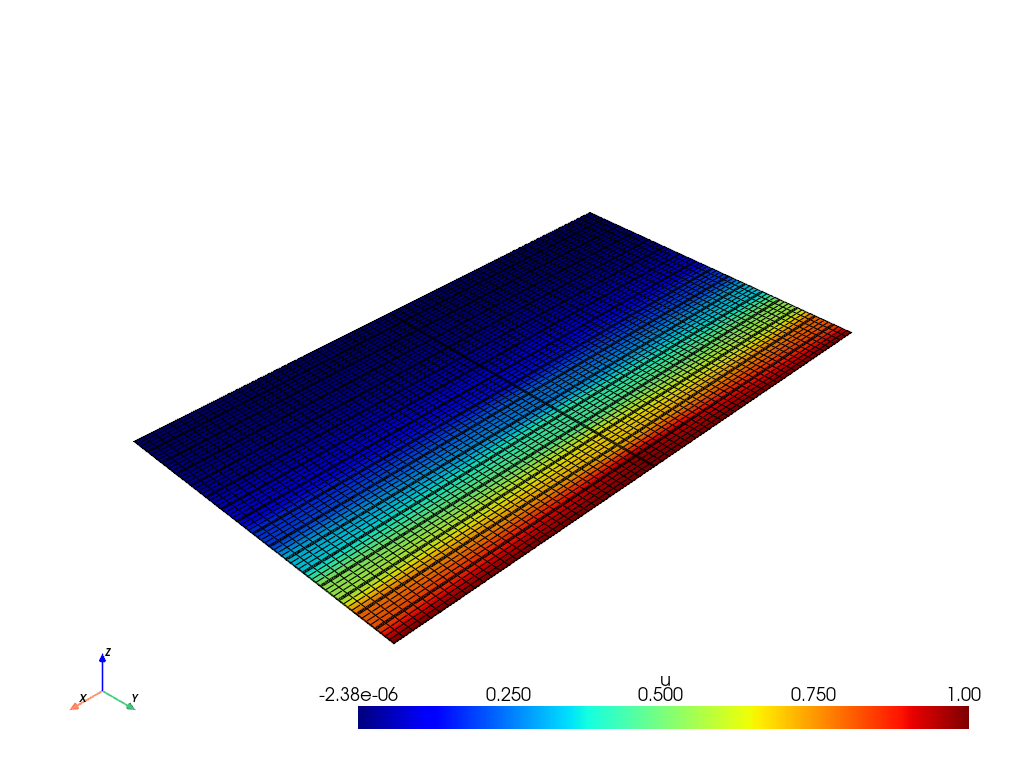

In [21]:
if hasPyvista:
    pyvista.start_xvfb()
    result = pyvista.read('vtk/SkinDiffusion_Final.vtu')

    pyvista.set_jupyter_backend('static')
    #pyvista.set_jupyter_backend('trame')

    print("Pyvista input: ")
    result.plot(scalars="u", show_edges=True, cmap='jet')